# Calculating weather regimes: a recipe

This recipe requires:
  - A Python environment on any operative system
  - `pandas`, `numpy`, `scikit-learn`
  - `xarray`, `cfgrib` (if the data is in GRIB format), `dask`, `netcdf4`
  - `eofs`
  - Climate data in Grib or NetCDF format

  Source: https://github.com/matteodefelice/a-recipe-for-weather-regimes/blob/main/recipe.ipynb (28 nov 2023)

## Climate data
I have shared a dataset with daily 500 hPa geopotential height from ERA5 [on a Zenodo repository](https://zenodo.org/record/8384348). 

# The recipe

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from eofs.xarray import Eof
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import time

In [2]:
PATH = "/net/pc230050/nobackup/users/duinen/LENTIS/present/zg500_d/"
# these should all be globals!
use_scaling = 0
n_eofs = 30
n_eofs_for_kmeans = 20 # was 20
n_clusters = 4 # was 4

In [3]:
def load_data(year, run_mid = 90):
    # The chunks options *should* improve the performance in opening the files
    filenames_1 = [f"{PATH}zg500_d_ECEarth3_h{i:03d}.nc" for i in range(10, run_mid)] # full data is 10, 85 and 85, 170.
    filenames_2 = [f"{PATH}zg500_d_ECEarth3_h{i:03d}.nc" for i in range(run_mid, 170)]

    # This one did work, but don't know how to calculate the ceners them? Mean or sum? Produces weird results.
    df_1 = (
        xr.open_mfdataset(filenames_1, concat_dim='time', combine="nested",
                        chunks={'longitude':31, 
                                'latitude': 16,
                                'time': -1})
        .convert_calendar('noleap')
    )
    df_1 = df_1.where(
        (df_1['time'].dt.month.isin([12, 1, 2])) & 
        (df_1['time'].dt.year.isin([year])) & # only use one year per run for cluster centroids, add others later.
        (df_1['lon'] < 30) & 
        (df_1['lat'] > 20) & 
        (df_1['lat'] < 80), 
        drop=True
    )

    len_per_run = int(len(df_1.time) / len(range(10, run_mid)))

    df_2 = (
        xr.open_mfdataset(filenames_2, concat_dim='time', combine="nested",
                        chunks={'longitude':31, 
                                'latitude': 16,
                                'time': -1})
        .convert_calendar('noleap')
    )
    df_2 = df_2.where(
        (df_2['time'].dt.month.isin([12, 1, 2, 3])) & 
        (df_2['time'].dt.year.isin([2005])) & # only use one year per run for cluster centroids, add others later.
        (df_2['lon'] < 30) & 
        (df_2['lat'] > 20) & 
        (df_2['lat'] < 80), 
        drop=True
    )
    
    df = xr.concat([df_1, df_2], dim = 'time')
    df = df.zg500.coarsen(lon = 3).mean().coarsen(lat = 3, boundary = 'trim').mean()
    return df, len_per_run

In [4]:
def load_data_per_run(run):
    filename = [f"{PATH}zg500_d_ECEarth3_h{run:03d}.nc"] 

    df = (
        xr.open_mfdataset(filename)
        .convert_calendar('noleap')
    )

    df = df.where(
        (df['time'].dt.month.isin([12, 1, 2])) & 
        (df['lon'] < 30) & 
        (df['lat'] > 20) & 
        (df['lat'] < 80), 
        drop=True
    )

    df = df.zg500.coarsen(lon = 3).mean().coarsen(lat = 3, boundary = 'trim').mean()
    return df

In [5]:
def calculate_anomaly(da, groupby_type="time.dayofyear"):
    gb = da.groupby(groupby_type)
    clim = gb.mean(dim="time")
    return gb - clim

In [6]:
def calculate_eofs(df_anom):
    coslat = np.cos(np.deg2rad(df_anom.coords['lat'].values)).clip(0., 1.)
    wgts   = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(df_anom, weights=wgts)
    eofs = solver.eofs(neofs=n_eofs)
    eofs_corr = solver.eofsAsCorrelation(neofs=n_eofs)
    explained_var = solver.varianceFraction()
    return solver, eofs, eofs_corr, explained_var #REVIEW: if I really need all this

In [7]:
def calculate_pcs(solver, df_anom):
    pcs = solver.projectField(df_anom,
                          neofs=n_eofs, 
                          eofscaling=use_scaling)

    df_pcs = (pcs
            .to_dataframe()
            .reset_index()
            .assign(run_index=lambda df: df.groupby(['time', 'mode']).cumcount())
            .pivot(index=['time', 'run_index'], columns='mode', values='pseudo_pcs')
            .add_prefix('EOF')
            )
    df_pcs.index = pd.to_datetime(df_pcs.index.get_level_values('time'))
    return df_pcs

In [8]:
def Kmeans_clustering(df_pcs):
    X_train = df_pcs.iloc[:, 0:n_eofs_for_kmeans].values
    km = KMeans(n_clusters=n_clusters, n_init=500, verbose=0, tol=0.000001, max_iter=500, random_state=3)
    km.fit(X_train)

    clus = pd.DataFrame(
        data=km.labels_, 
        columns=['cluster_id'], 
        index=df_pcs.index).reset_index()
    clus.rename(columns={'time': 'date'}, inplace=True)

    clus.set_index('date', inplace=True)

    # calculate centroids
    cluster_centers = pd.DataFrame(
        km.cluster_centers_, 
        columns=[f'eof{i}' for i in np.arange(1,n_eofs_for_kmeans+1)]
        )

    cluster_center_array = xr.DataArray(
        cluster_centers.values, 
        coords=[np.arange(0, n_clusters), np.arange(0, n_eofs_for_kmeans) ], 
        dims=['centroids', 'mode'])
    
    return clus, cluster_center_array

In [9]:
def original_space(cluster_center_array, eofs):
    eigenvectors20 = eofs.loc[0:n_eofs_for_kmeans, ...]
    recons_cluster_centers_weighted = cluster_center_array.dot(eigenvectors20)

    lons = recons_cluster_centers_weighted.coords['lon'].values 
    lats = recons_cluster_centers_weighted.coords['lat'].values

    coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
    wgts = np.sqrt(coslat)

    weights_array = xr.DataArray(wgts, coords=[lats], dims=['lat'])
    recons_cluster_centers_unweighted = recons_cluster_centers_weighted / weights_array
    return recons_cluster_centers_unweighted


In [10]:
def plot_clusters(recons_cluster_centers_unweighted, lons, lats):
    for i in np.arange(0, n_clusters):
        plt.figure(figsize=(15, 8))
        ax = plt.axes(
            projection=ccrs.Orthographic(central_longitude=-30, central_latitude=50))
        
        vals = recons_cluster_centers_unweighted[i, :, :].squeeze().values

        fill = ax.contourf(
            lons,
            lats,
            recons_cluster_centers_unweighted[i, :, :].squeeze(),
            levels = np.linspace(-200, 200, 41),
            cmap=plt.cm.RdBu_r,
            extend = 'both',
            transform=ccrs.PlateCarree())

        cb = plt.colorbar(fill,
                        orientation='vertical',
                        label='500 hPa height anomaly [m]',
                        extend='both')
        title = f'cluster n. {i}'
        ax.coastlines(resolution='50m')
        ax.gridlines()
        
        plt.title(title, fontsize=20)
        plt.show()

In [11]:
def assign_cluster_df(X_assign, centroids, run_id, df):
# def assign_cluster_df(X_assign, centroids, df):
    assignments = []
    for data_point in X_assign:
        distances = np.linalg.norm(centroids - data_point, axis=1)
        cluster_assignment = np.argmin(distances)
        assignments.append(cluster_assignment)

  
    df_cluster = pd.DataFrame({
        'time': df['time'].values,
        'run': run_id,
        'cluster_id': assignments
    })

    return df_cluster

In [12]:
#TODO: Add this part, make sure it works also for the later assigned clusters

# # Assume 'kmeans' is your trained KMeans model and 'data' is your dataset
# cluster_centers = km.cluster_centers_

# # Get the cluster assignment for each sample
# labels = km.labels_

# # Initialize an empty list to store the correlation coefficients
# correlation_coefficients = []

# # For each sample, calculate the Pearson correlation coefficient with its assigned cluster center
# for i in tqdm(range(len(X_train))):
#     corr, _ = pearsonr(X_train[i], cluster_centers[labels[i]])
#     correlation_coefficients.append(corr)
# #add the correlation coefficients to the dataframe
# clus['centroid_similarity'] = correlation_coefficients

## From here, starting to combine functions

In [13]:
def gen_clusters(year = 2005):
    print(f"Generating clusters for year {year}")
    print("Loading data")
    # df, len_per_run = load_data(year) 
    df, len_per_run = load_data(year) # Now using data that already has anomalies calculated
    
    print("Calculating anomalies")
    start_time = time.time()
    df_anom = df.map_blocks(calculate_anomaly, template=df.load())
    df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()
    end_time = time.time()
    print(f"Anomalies calculated in {end_time - start_time} seconds")

    print("Calculating EOFs")
    start_time = time.time()
    solver, eofs, eofs_corr, explained_var = calculate_eofs(df_anom)
    end_time = time.time()
    print(f"EOFs calculated in {end_time - start_time} seconds")
    
    print("Calculating PCs")
    df_pcs = calculate_pcs(solver, df_anom)

    print("Performing clustering")
    clus, cluster_center_array = Kmeans_clustering(df_pcs)
    recons_cluster_centers_unweighted = original_space(cluster_center_array, eofs)

    print("Plotting clusters")
    lons = recons_cluster_centers_unweighted.coords['lon'].values 
    lats = recons_cluster_centers_unweighted.coords['lat'].values
    plot_clusters(recons_cluster_centers_unweighted, lons, lats)

    print("Done!")
    return clus, cluster_center_array, recons_cluster_centers_unweighted, solver, eofs

Generating clusters for year 2005
Loading data
Calculating anomalies


/tmp/ipykernel_827860/4147233730.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()


Anomalies calculated in 376.7891592979431 seconds
Calculating EOFs
EOFs calculated in 6.94605827331543 seconds
Calculating PCs
Performing clustering
Plotting clusters


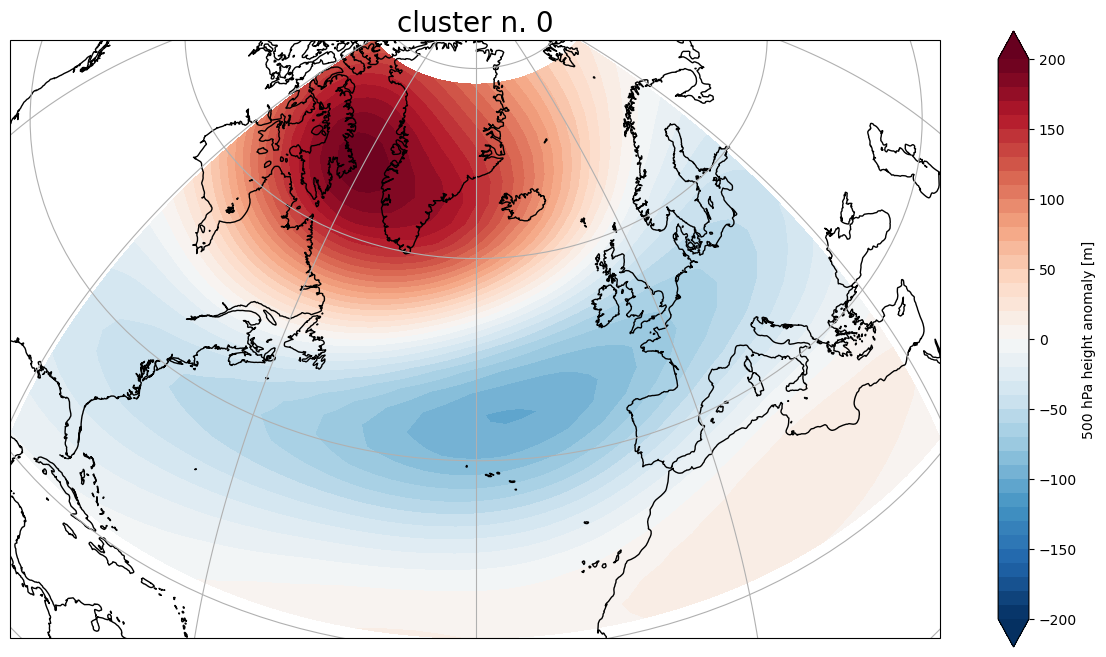

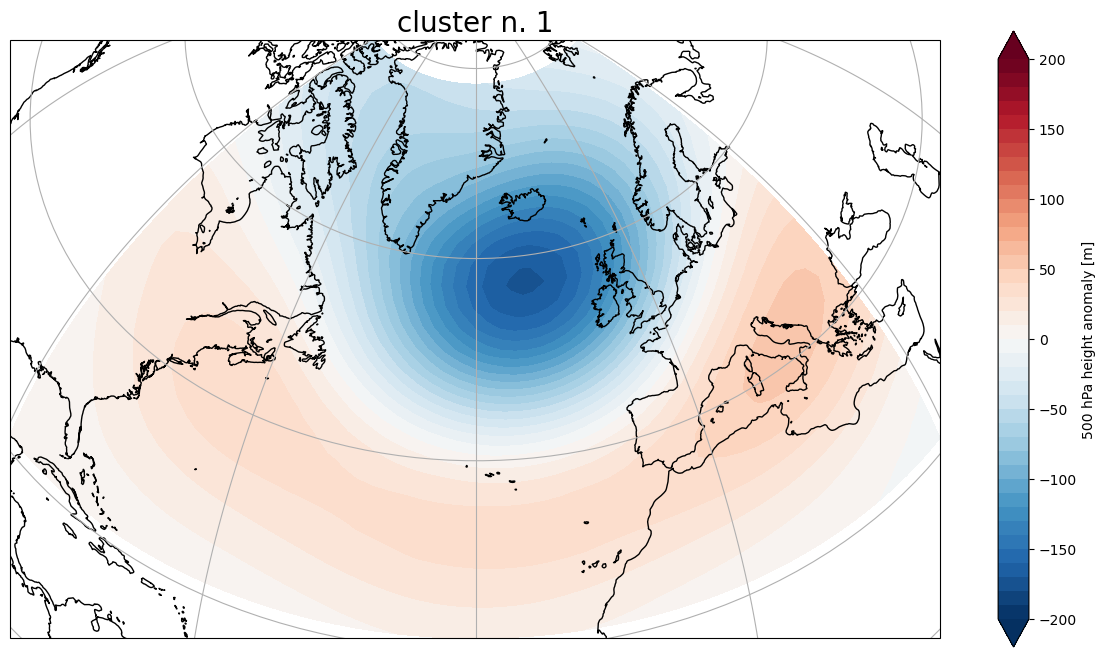

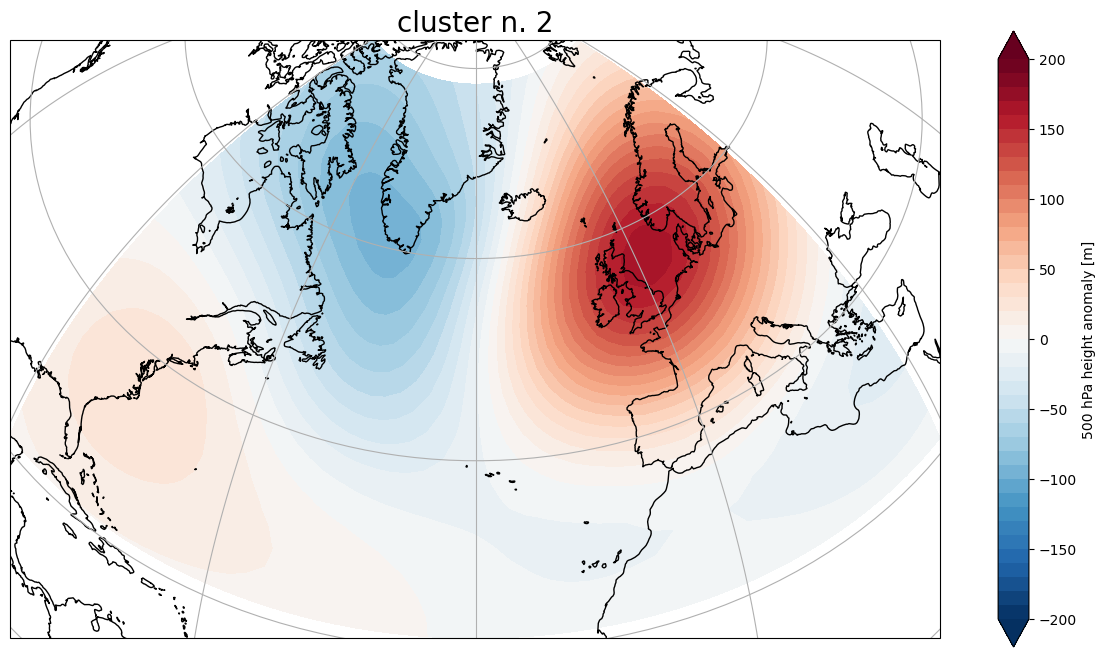

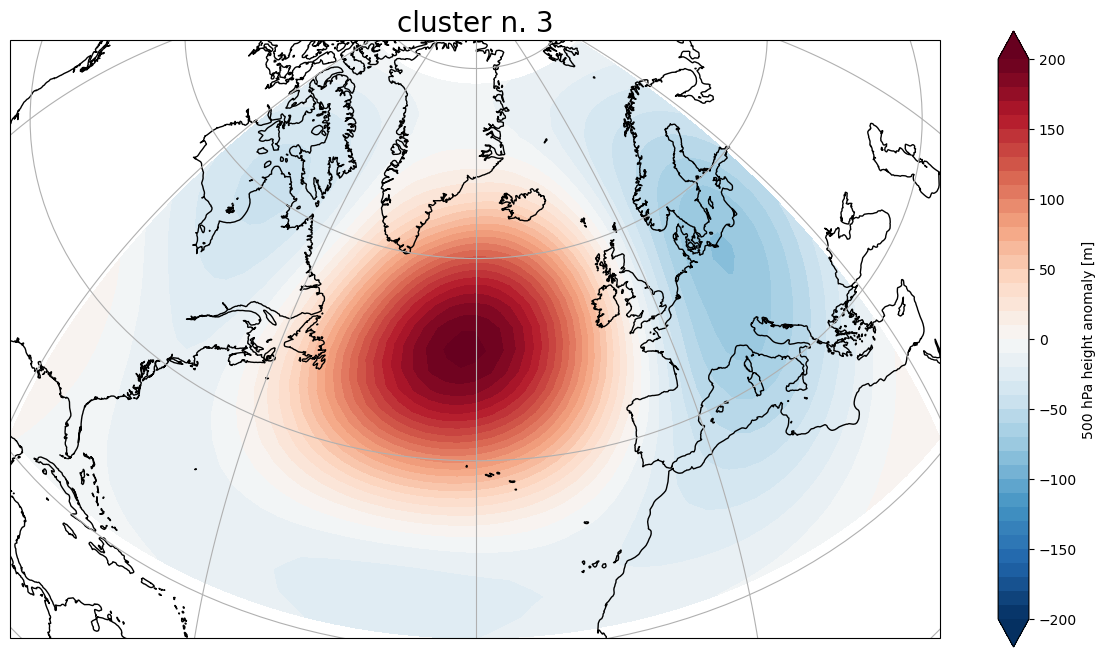

Done!


In [14]:
clus, cluster_center_array, recons_cluster_centers_unweighted, solver, eofs = gen_clusters()

### Now assign all data to the computed centroids

In [27]:
def assign_to_cluster_final(run, centroids, eofs, solver):
    df = load_data_per_run(run)    
    df_anom = df.map_blocks(calculate_anomaly, template=df.load())
    df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()
    df_pcs = calculate_pcs(solver, df_anom)
    X_assign = df_pcs.iloc[:, 0:n_eofs_for_kmeans].values

    assignments = []
    all_errors = [[]]
    
    for data_point in X_assign:
        distances = np.linalg.norm(centroids - data_point, axis=1)
        # this part to add no-regime part if there is no significant improvement
        sorted_distances = np.sort(distances)
        if sorted_distances[1] <= sorted_distances[0] * 1.05: # cluster should be significantly better
            cluster_assignment = 4 # no regime
        else:
            cluster_assignment = np.argmin(distances)
        # cluster_assignment = np.argmin(distances)
        assignments.append(cluster_assignment)
        all_errors = np.append(all_errors, distances)
    
    df_cluster = pd.DataFrame({
        'time': df['time'].values,
        'run': run,
        'cluster_id': assignments,
        # 'error': all_errors,
        # 'error_all': errors_all
    })
    
    df_cluster.to_csv(f"../Results/clusters_v1/clusters_{run}.csv")
    # return df_cluster

In [28]:
for run in tqdm(range(10, 170)):
    assign_to_cluster_final(run, cluster_center_array, eofs, solver)

  0%|          | 0/160 [00:00<?, ?it/s]

/tmp/ipykernel_827860/1521807345.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()
/tmp/ipykernel_827860/1521807345.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()
/tmp/ipykernel_827860/1521807345.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of 

### Not necessary, but gives some insight

/tmp/ipykernel_827860/997050846.py:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()


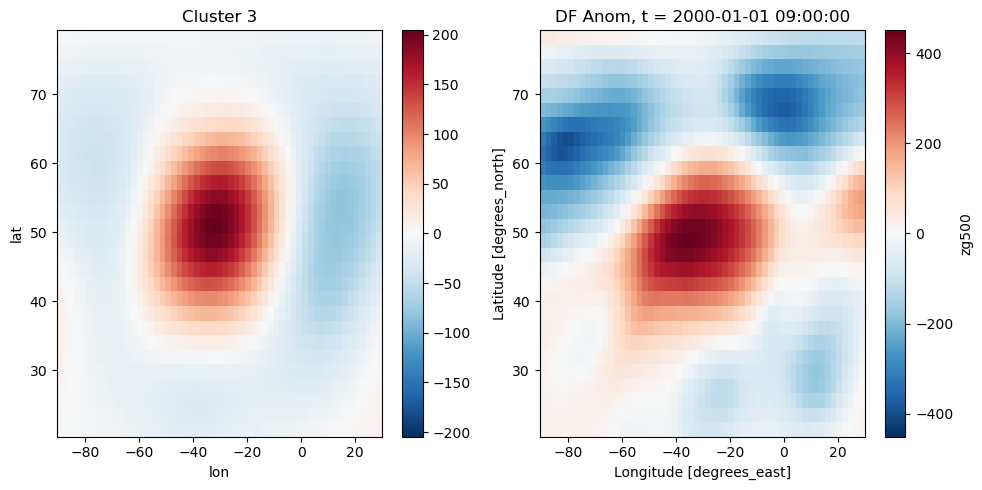

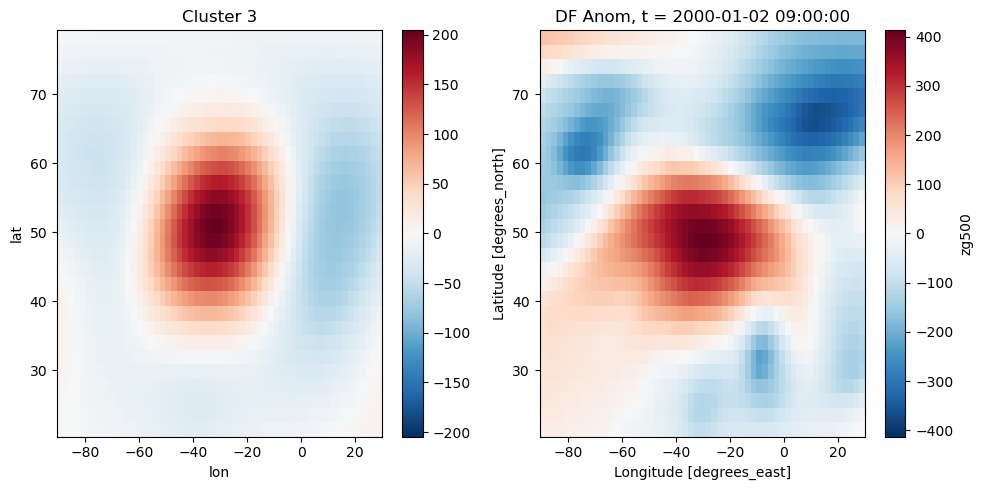

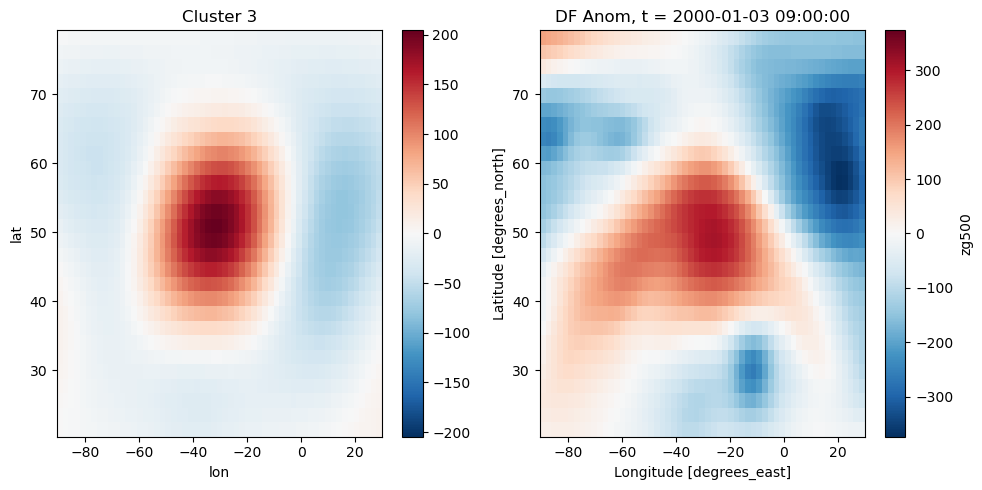

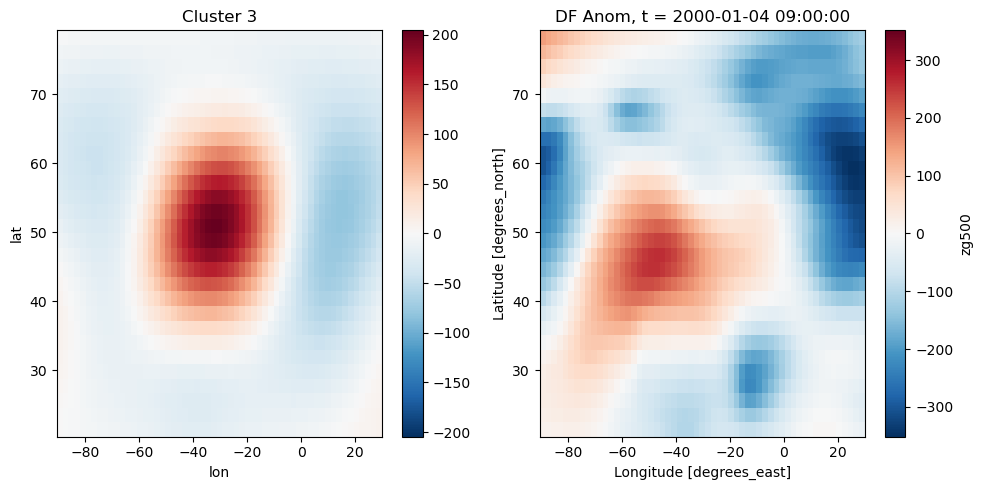

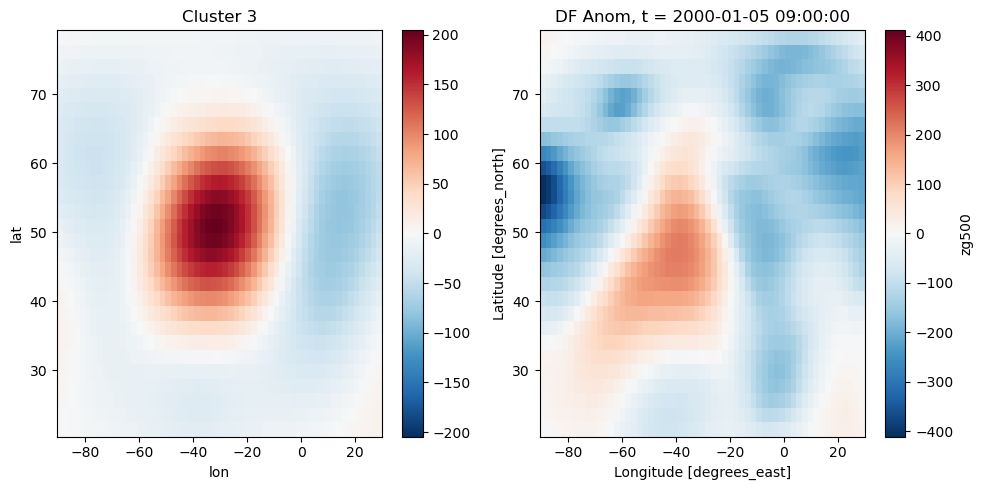

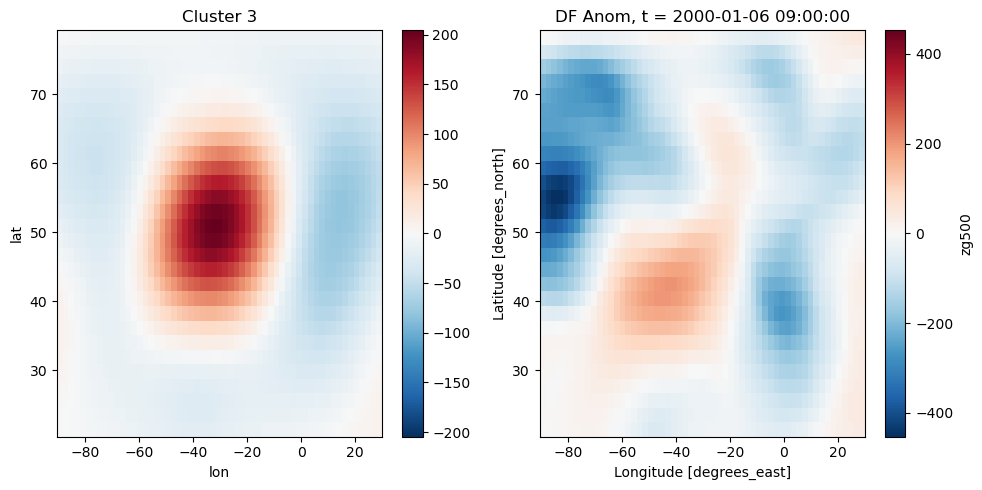

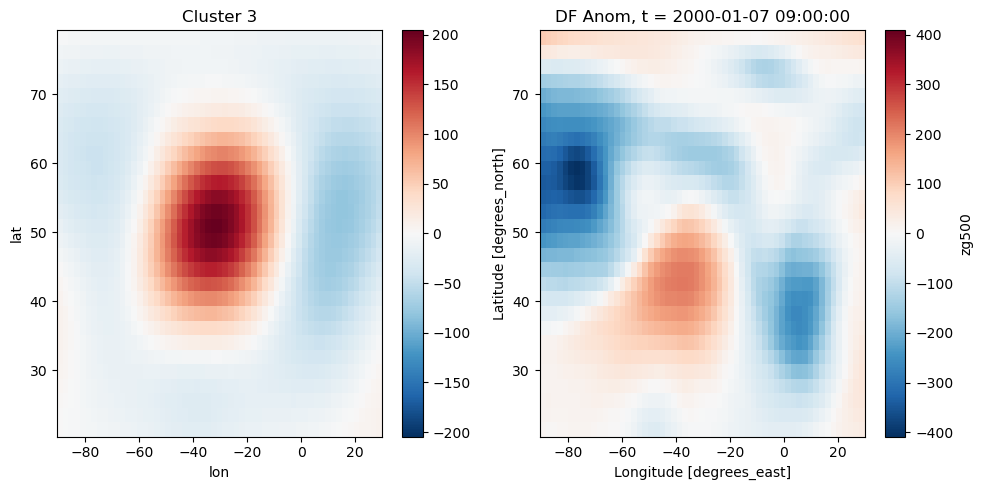

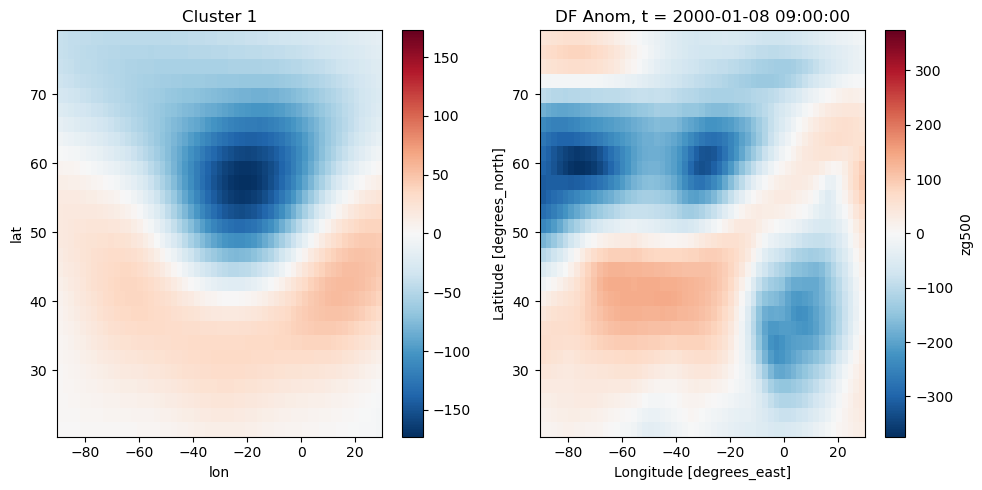

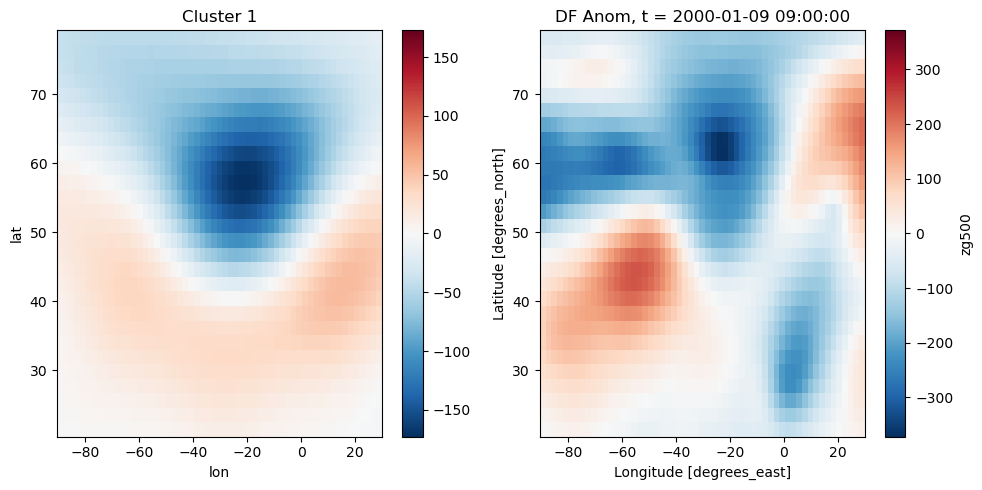

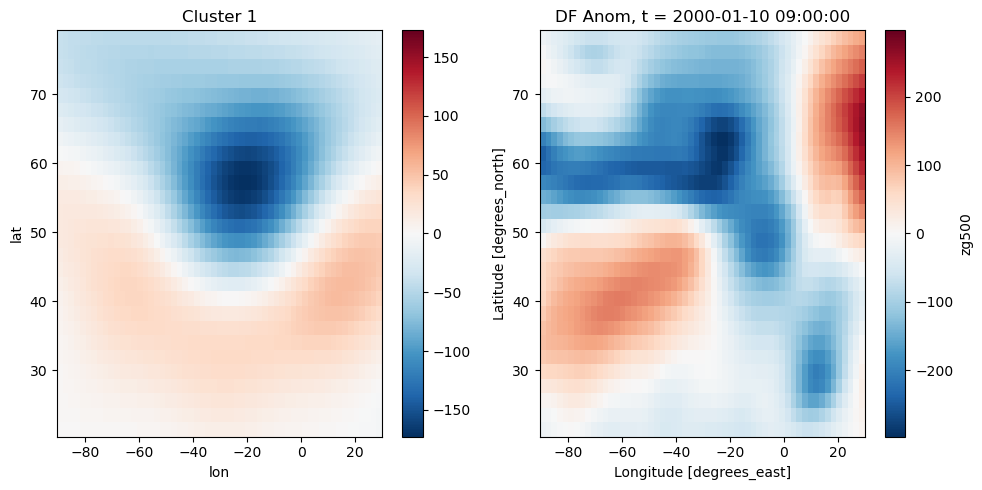

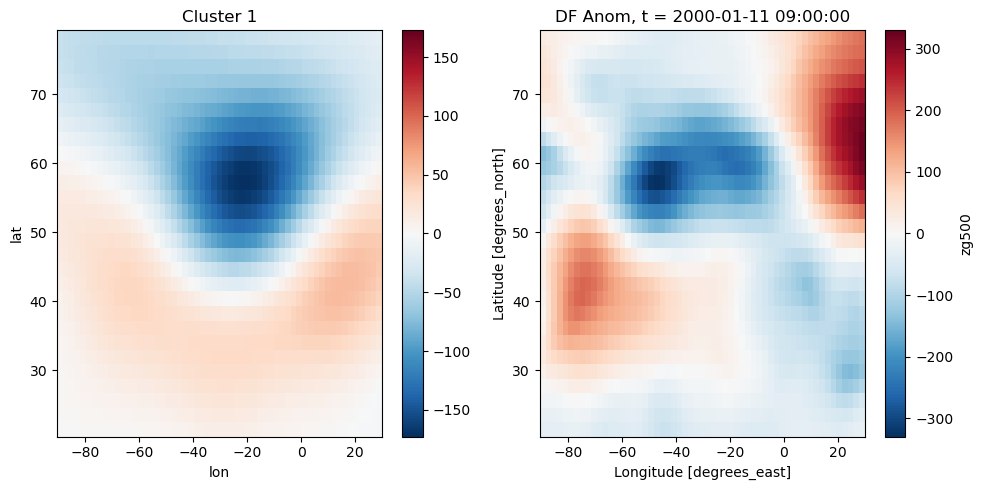

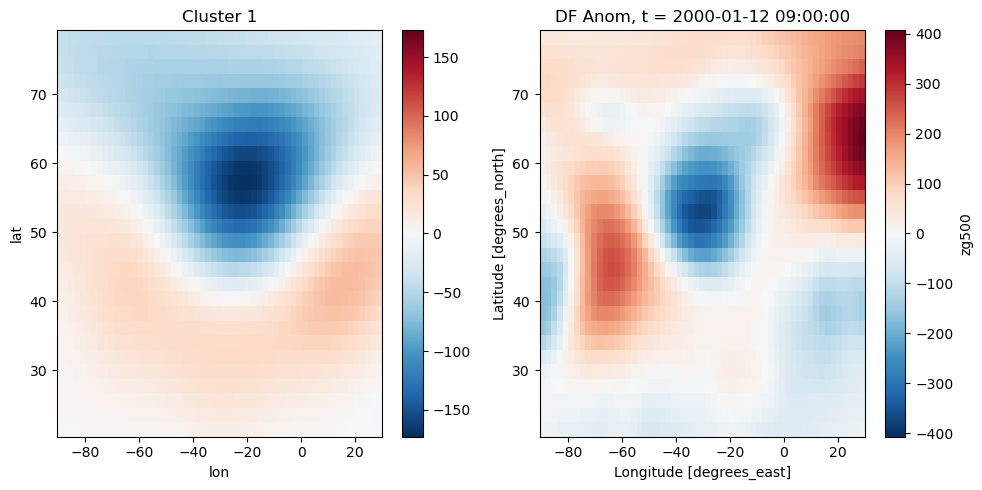

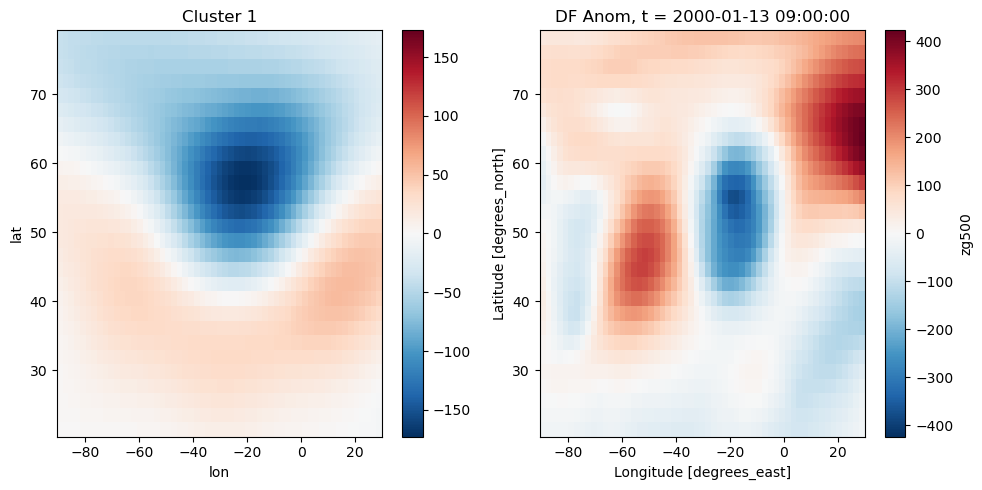

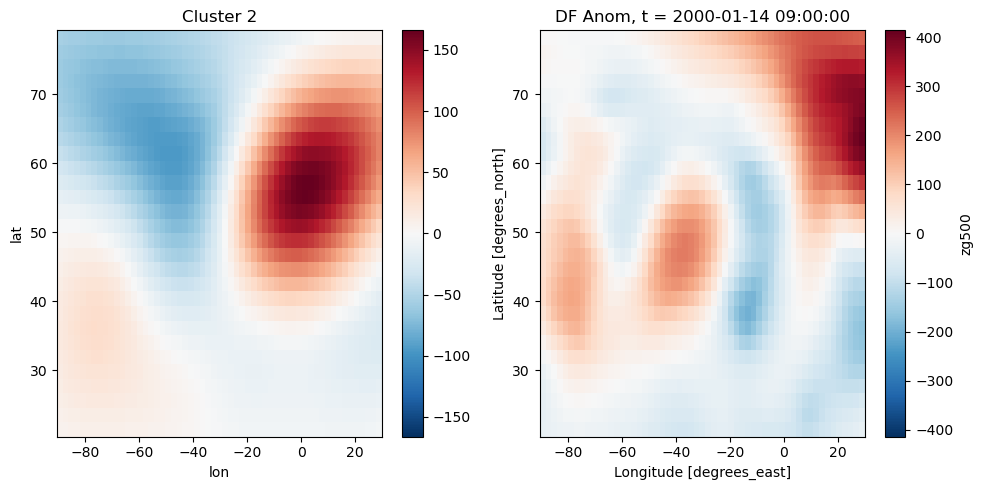

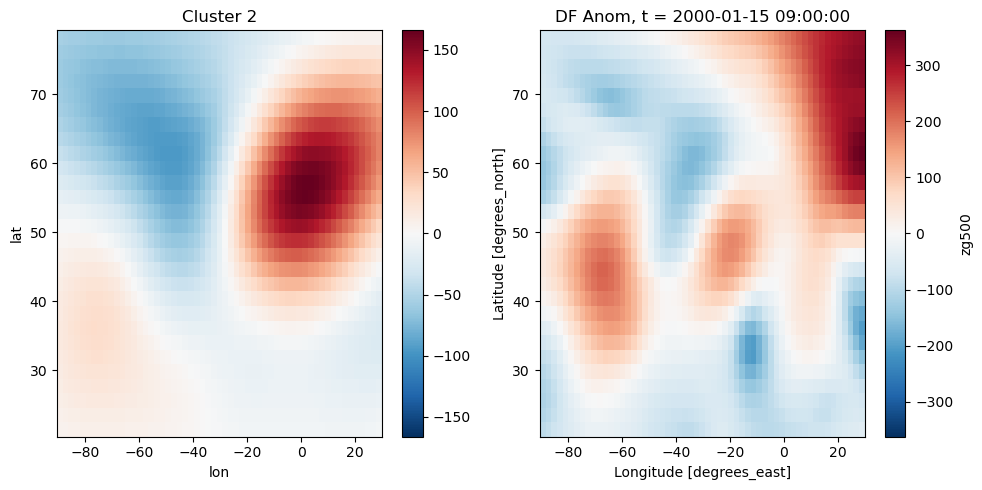

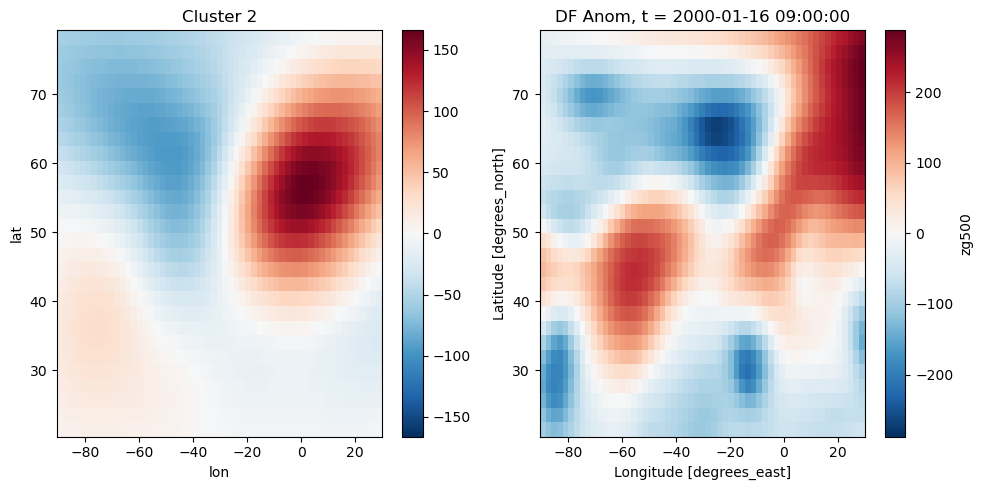

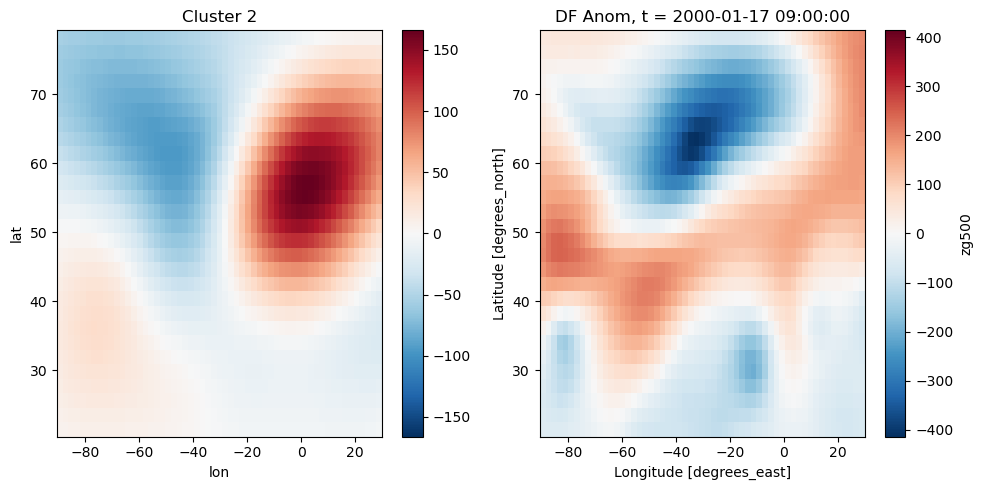

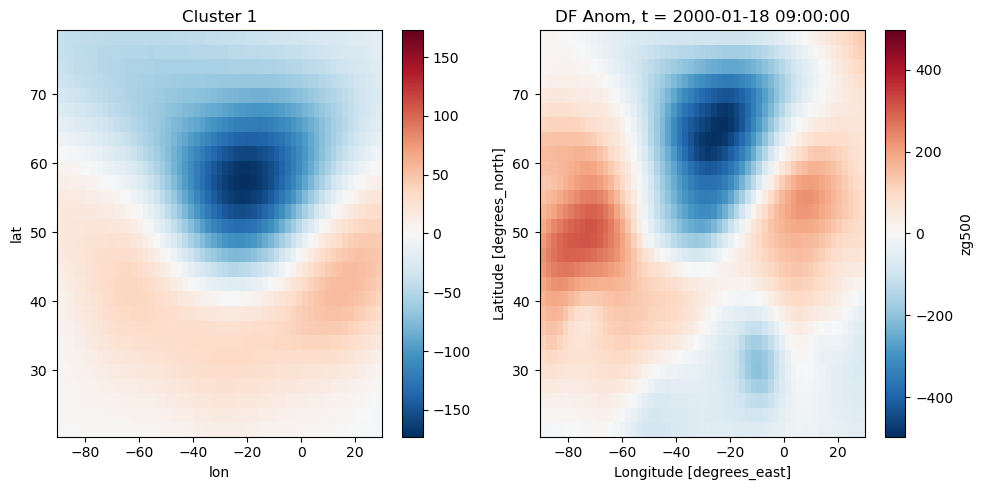

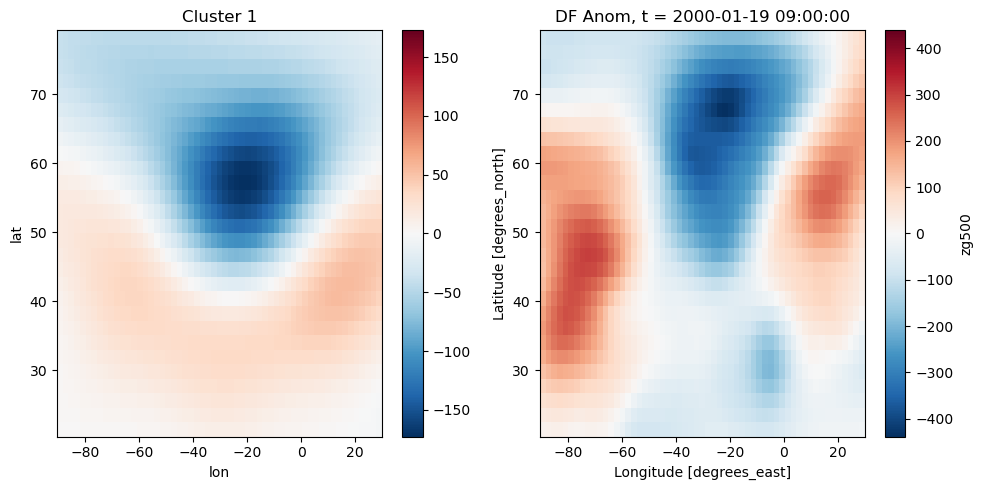

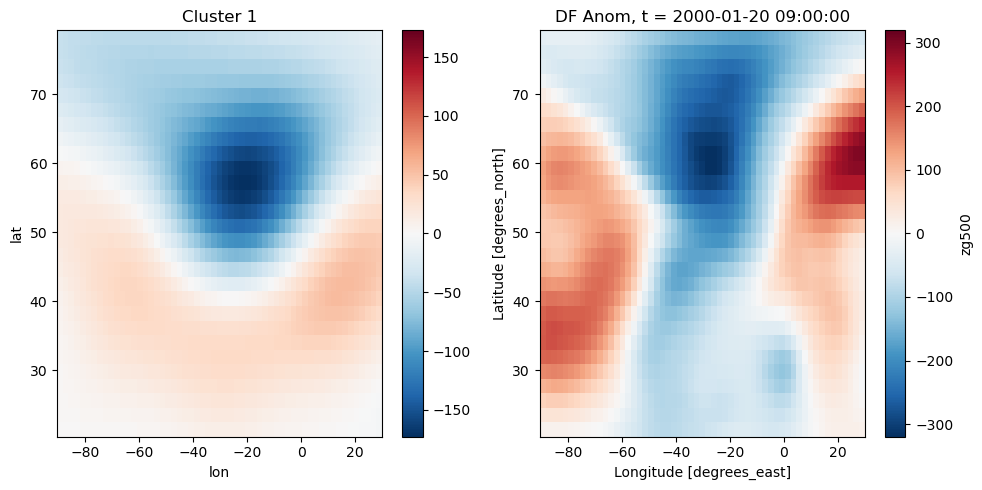

In [29]:
run = 10
centroids = cluster_center_array

df = load_data_per_run(run)    
df_anom = df.map_blocks(calculate_anomaly, template=df.load())
df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()
# solver, eofs, eofs_corr, explained_var = calculate_eofs(df_anom)
df_pcs = calculate_pcs(solver, df_anom)
X_assign = df_pcs.iloc[:, 0:n_eofs_for_kmeans].values

eof_origin = original_space(cluster_center_array, eofs)
# assignments = []
# all_errors = [[]]

for i in range(20):
    data_point = X_assign[i]

    distances = np.linalg.norm(data_point - cluster_center_array, axis=1)
    cluster_assignment = np.argmin(distances)
    # assignments.append(cluster_assignment)
    # all_errors.append(distances)

    # plotting

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    eof_origin[cluster_assignment].plot(ax=axs[0])
    axs[0].set_title(f'Cluster {cluster_assignment}')

    df_anom.isel(time = i).plot(ax=axs[1])
    axs[1].set_title(f'DF Anom, t = {df.time[i].values}')


    plt.tight_layout()
    plt.show()